In [1]:
print("Starting setups...")
import sys
import os

Starting setups...


In [2]:
dir_path = os.getcwd()
parent_dir = os.path.dirname(dir_path)
home_dir = os.path.dirname(parent_dir)
print("dir_path is", dir_path)
print("parent_dir is", parent_dir)
print("home_dir is", home_dir)

dir_path is /Users/zoe/Documents/Bank-account-fraud/code/model_tuning
parent_dir is /Users/zoe/Documents/Bank-account-fraud/code
home_dir is /Users/zoe/Documents/Bank-account-fraud


In [3]:
import yaml
print(home_dir+'/params.yaml')
with open(home_dir+'/params.yaml', 'r') as file:
    params = yaml.safe_load(file)
params

/Users/zoe/Documents/Bank-account-fraud/params.yaml


{'data_location': '/data',
 'output_location': '/output',
 'code_location': '/code'}

In [4]:
data_folder = home_dir+params['data_location']
print('Data is stored at', data_folder)

Data is stored at /Users/zoe/Documents/Bank-account-fraud/data


In [5]:
with open(dir_path+"/params.yaml", "r") as file:
    config = yaml.safe_load(file)

print(f"Current configuration is: {config}")

Current configuration is: {'tuning': {'method': 'random_search', 'random_search': {'param_distributions': {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}, 'n_iter': 50, 'cv': 3, 'scoring': 'roc_auc', 'random_state': 42}, 'grid_search': {'param_grid': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 6, 9], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}, 'cv': 5, 'scoring': 'roc_auc'}, 'bayesian_optimization': {'param_bounds': {'n_estimators': [50, 500], 'learning_rate': [0.01, 0.2], 'max_depth': [3, 10], 'subsample': [0.5, 1.0], 'colsample_bytree': [0.5, 1.0]}, 'init_points': 5, 'n_iter': 25, 'scoring': 'roc_auc'}}}


In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings as wr
wr.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier

sys.path.append(os.path.abspath("model_tuning"))
from functions import *

In [7]:
print("Reading training and test data...")
X_train = pd.read_csv(f"{home_dir}/data/x_train_data.csv", index_col=0)
y_train = pd.read_csv(f"{home_dir}/data/y_train_data.csv", index_col=0)
X_test = pd.read_csv(f"{home_dir}/data/x_test_data.csv", index_col=0)
y_test = pd.read_csv(f"{home_dir}/data/y_test_data.csv", index_col=0)

# X_train_smote = pd.read_csv(f"{parent_dir}/data/x_train_data_smote.csv", index_col=0)
# y_train_smote = pd.read_csv(f"{parent_dir}/data/y_train_data_smote.csv", index_col=0)

Reading training and test data...


# Baseline model

Assumptions:
1. imbalaned dataset with low percentage of positive cases, so we use AUC as the measuring metrics
2. assume it's more costly to have higher FN(misclassified fraud cases as not fraud) than higher FP (false alarm for not fraud as fraud). So we aim for a higher recall (higher true positive rate & lower false negative rate)

# function to get all evaluation metrics

In [55]:
# from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay

# def evaluate_model_performance(model, X_test, y_test, threshold=0.5):
#     preds = model.predict_proba(X_test)[:, 1]
#     auc_score = roc_auc_score(y_test, preds)

#     # Classify based on the threshold
#     pred_bool = (preds >= threshold).astype(int)

#     # Compute confusion matrix metrics
#     tn, fp, fn, tp = confusion_matrix(y_test, pred_bool).ravel()
#     cm = confusion_matrix(y_test, pred_bool)
#     tpr = tp / (tp + fn)  # True Positive Rate
#     fpr = fp / (fp + tn)  # False Positive Rate

#     # Compute ROC curve
#     fpr_curve, tpr_curve, thresholds = roc_curve(y_test, preds)

#     # Print the results
#     print(f"Recall (TPR): {tpr:.4f}")
#     print(f"False Positive Rate (FPR): {fpr:.4f}")
#     print(f'ROC AUC: {auc_score:.5f}')

#     return {
#         "PREDS": preds, 
#         "PREDS_BOOL": pred_bool, 
#         "TN": tn, 
#         "FP": fp, 
#         "FN": fn, 
#         "TP": tp, 
#         # pr_curve, tpr_curve, thresholds
#         "TPR": tpr,
#         "FPR": fpr,
#         "ROC AUC": auc_score,
#         "Confusion Matrix": cm,
#         "ROC Curve": (fpr_curve, tpr_curve),
#     }

### use xgb.cv to provide a baseline model eval

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
default_model = XGBClassifier()
default_params = default_model.get_params()
print(default_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [147]:
# def objective(hyperparameters, dtrain, iteration):
#     """Objective function for grid and random search. Returns
#        the cross validation score from a set of hyperparameters."""
    
#     # Perform n_folds cross validation
#     cv_results = xgb.cv(params = hyperparameters, 
#                         dtrain = dtrain, num_boost_round = 10000, nfold = 10, 
#                         early_stopping_rounds = 5, metrics = 'auc', seed = 42,
#                         verbose_eval=2, maximize=True)
    
#     # results to retun
#     score = cv_results['test-auc-mean'].max()
#     # estimators = len(cv_results['test-auc-mean'])
#     # hyperparameters['n_estimators'] = estimators 
    
#     return [cv_results, score, hyperparameters, iteration]

In [10]:
r = objective(default_params, dtrain, iteration=1)

[0]	train-auc:0.96025+0.00007	test-auc:0.96021+0.00053
[2]	train-auc:0.97327+0.00113	test-auc:0.97318+0.00103
[4]	train-auc:0.97959+0.00037	test-auc:0.97951+0.00043
[6]	train-auc:0.98297+0.00034	test-auc:0.98291+0.00052
[8]	train-auc:0.98693+0.00041	test-auc:0.98685+0.00056
[10]	train-auc:0.99102+0.00078	test-auc:0.99092+0.00084
[12]	train-auc:0.99293+0.00052	test-auc:0.99285+0.00054
[14]	train-auc:0.99402+0.00038	test-auc:0.99395+0.00042
[16]	train-auc:0.99485+0.00023	test-auc:0.99477+0.00031
[18]	train-auc:0.99541+0.00019	test-auc:0.99532+0.00029
[20]	train-auc:0.99589+0.00018	test-auc:0.99580+0.00022
[22]	train-auc:0.99619+0.00020	test-auc:0.99609+0.00024
[24]	train-auc:0.99646+0.00017	test-auc:0.99635+0.00021
[26]	train-auc:0.99668+0.00011	test-auc:0.99655+0.00015
[28]	train-auc:0.99686+0.00013	test-auc:0.99673+0.00019
[30]	train-auc:0.99701+0.00010	test-auc:0.99687+0.00017
[32]	train-auc:0.99714+0.00009	test-auc:0.99700+0.00015
[34]	train-auc:0.99726+0.00006	test-auc:0.99711+0.000

In [18]:
default_cv =  {
            "score": r[1], 
            "params": r[2], 
            "iterations": r[3]
        }
default_cv

{'score': np.float64(0.9982889029064763),
 'params': {'objective': 'binary:logistic',
  'base_score': None,
  'booster': None,
  'callbacks': None,
  'colsample_bylevel': None,
  'colsample_bynode': None,
  'colsample_bytree': None,
  'device': None,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'feature_types': None,
  'gamma': None,
  'grow_policy': None,
  'importance_type': None,
  'interaction_constraints': None,
  'learning_rate': None,
  'max_bin': None,
  'max_cat_threshold': None,
  'max_cat_to_onehot': None,
  'max_delta_step': None,
  'max_depth': None,
  'max_leaves': None,
  'min_child_weight': None,
  'missing': nan,
  'monotone_constraints': None,
  'multi_strategy': None,
  'n_estimators': None,
  'n_jobs': None,
  'num_parallel_tree': None,
  'random_state': None,
  'reg_alpha': None,
  'reg_lambda': None,
  'sampling_method': None,
  'scale_pos_weight': None,
  'subsample': None,
  'tree_method': None,
  'validate_parameters'

In [13]:
default_model = train_model(default_params, dtrain, dtest)

[0]	training-logloss:0.51093	testing-logloss:0.48024
[2]	training-logloss:0.33799	testing-logloss:0.31929
[4]	training-logloss:0.25764	testing-logloss:0.24440


Recall (TPR): 0.3457
False Positive Rate (FPR): 0.0474
ROC AUC: 0.81835


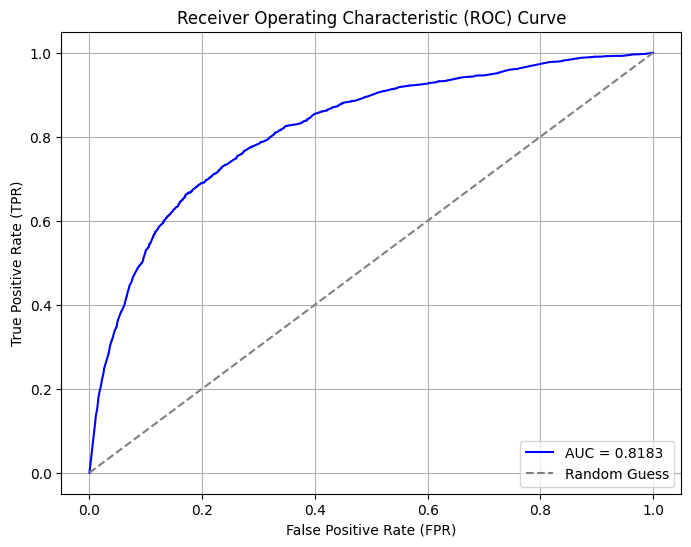

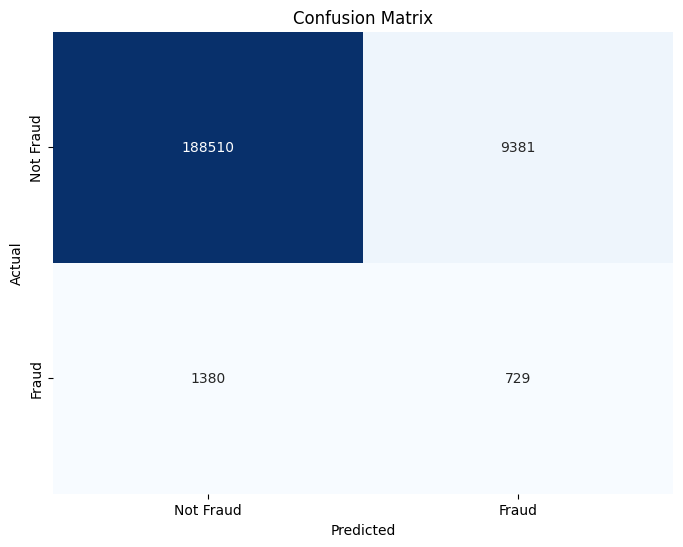

{'PREDS': array([0.10538135, 0.09202541, 0.14346935, ..., 0.08144739, 0.1062959 ,
       0.08547435], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(188510), 'FP': np.int64(9381), 'FN': np.int64(1380), 'TP': np.int64(729), 'TPR': np.float64(0.3456614509246088), 'FPR': np.float64(0.04740488450712766), 'ROC AUC': np.float64(0.8183495062115641), 'Confusion Matrix': array([[188510,   9381],
       [  1380,    729]]), 'ROC Curve': (array([0.        , 0.00977811, 0.01066244, ..., 0.98749311, 0.98779126,
       1.        ]), array([0.        , 0.1161688 , 0.12565197, ..., 0.99715505, 0.99762921,
       1.        ]))}


In [16]:
baseline_result = evaluate_model_performance3(default_model, 
                                              X_test, y_test, 
                                              threshold=0.5, 
                                              plot_roc_curve=True, plot_confusion_matrix=True)
print(baseline_result)

In [19]:
compare = pd.DataFrame({
    'y':y_test.fraud_bool,
    'y_hat':baseline_result["PREDS_BOOL"]
})

compare[compare.y==1].sum()

y        2109
y_hat     729
dtype: int64

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to get the number of estimators.

how is the true negative different from the one's that are not captured as fraud;
exmaine the true negatives and go back to the features to alter the figure and let the model learn from new features 

# Tuning

## objective function

# Random search first

In [35]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

In [36]:
def write_csv_test(outfile, iteration=5):
    results = pd.DataFrame(columns = ['score', 'params', 'iterations'],index = list(range(iteration)))
    for i in range(iteration): 
        results.loc[i, :] = {
            "score": i+5, 
            "params": i+6, 
            "iterations": i+7
        }

        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(results)

        of_connection.close()
    results.sort_values('score', ascending = False, inplace = True)
    # results.reset_index(inplace = True)
    return results
        
results = write_csv_test(out_file)
results

,score,params,iterations
4,9,10,11
3,8,9,10
2,7,8,9
1,6,7,8
0,5,6,7


In [80]:
# def random_search(dtrain, param_grid, out_file, iteration=1):
#     best_auc = 0
#     best_params = {}
#     results = pd.DataFrame(columns = ['score', 'params', 'iterations'], 
#                           index = list(range(iteration)))
#     for i in range(iteration): 
#         param_grid = param_grid
#         eval_results = objective(param_grid, dtrain, i)
#         results.loc[i, :] = {
#             "score": eval_results[1], 
#             "params": eval_results[2], 
#             "iterations": eval_results[3]
#         }

#         of_connection = open(out_file, 'a')
#         writer = csv.writer(of_connection)
#         writer.writerow([eval_results[1], eval_results[2], eval_results[3]])

#         of_connection.close()
        
#         auc_score = eval_results[1]
        
#         if auc_score > best_auc:
#             best_auc = auc_score
#             best_params = eval_results[2]

#     results.sort_values('score', ascending = False, inplace = True)
#     results.reset_index(inplace = True)
        
#     return best_params, best_auc

# def train_model(best_params, dtrain, dtest):
#     # Train the final model with the best hyperparameters
#     final_random_search_model = xgb.train(
#         params=best_params,
#         dtrain=dtrain,
#         num_boost_round=10000,
#         early_stopping_rounds=5,
#         evals=[(dtrain, 'training'), (dtest, 'testing')],
#         maximize=True,
#         verbose_eval=2
#     )
#     return final_random_search_model

In [34]:
# def fit_xgb_binary(xgb_train, xgb_test, iterations=1):
#     best_auc = 0
#     best_params = {}

#     for _ in range(iterations):
#         # Random hyperparameters for this iteration
#         hparams = {
#             'eta': np.random.uniform(0.01, 0.6),
#             'lambda': np.random.uniform(0.01, 0.2),
#             'alpha': np.random.uniform(0.01, 0.2),
#             'gamma': np.random.uniform(0, 20),
#             'max_depth': np.random.randint(3, 15),
#             'subsample': np.random.uniform(0.5, 1),
#             'colsample_bytree': np.random.uniform(0.5, 1),
#             'objective': 'binary:logistic',
#             'eval_metric': 'auc',
#             'min_child_weight': np.random.uniform(0.8, 1.2)
#         }

#         # Cross-validation
#         xgb_cv = xgb.cv(
#             params=hparams,
#             dtrain=xgb_train,
#             num_boost_round=10000,
#             nfold=10,
#             early_stopping_rounds=5,
#             metrics=['auc'],
#             maximize=True,
#             verbose_eval=2,
#             seed=1234
#         )

#         # Get the best AUC score from CV
#         best_iteration = xgb_cv['test-auc-mean'].idxmax()
#         auc_score = xgb_cv['test-auc-mean'][best_iteration]

#         # Update best params if the new score is better
#         if auc_score > best_auc:
#             best_auc = auc_score
#             best_params = hparams

#     # Train the final model with the best hyperparameters
#     final_random_search_model = xgb.train(
#         params=best_params,
#         dtrain=xgb_train,
#         num_boost_round=10000,
#         early_stopping_rounds=5,
#         evals=[(xgb_train, 'training'), (xgb_test, 'testing')],
#         maximize=True,
#         verbose_eval=2
#     )

#     return final_random_search_model, best_params, best_auc

In [23]:
param_grid = {
    'eta': np.random.uniform(0.01, 0.6),
    'lambda': np.random.uniform(0.01, 0.2),
    'alpha': np.random.uniform(0.01, 0.2),
    'gamma': np.random.uniform(0, 20),
    'max_depth': np.random.randint(3, 15),
    'subsample': np.random.uniform(0.5, 1),
    'colsample_bytree': np.random.uniform(0.5, 1),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': np.random.uniform(0.8, 1.2)
}

best_params, best_auc = random_search(dtrain, param_grid, out_file, iteration=1)

[0]	train-auc:0.96667+0.00065	test-auc:0.96657+0.00073
[2]	train-auc:0.97534+0.00054	test-auc:0.97526+0.00072
[4]	train-auc:0.97866+0.00057	test-auc:0.97853+0.00073
[6]	train-auc:0.98155+0.00024	test-auc:0.98146+0.00047
[8]	train-auc:0.98298+0.00030	test-auc:0.98288+0.00054
[10]	train-auc:0.98443+0.00027	test-auc:0.98431+0.00033
[12]	train-auc:0.98547+0.00023	test-auc:0.98537+0.00032
[14]	train-auc:0.98649+0.00029	test-auc:0.98640+0.00030
[16]	train-auc:0.98750+0.00031	test-auc:0.98741+0.00032
[18]	train-auc:0.98885+0.00022	test-auc:0.98876+0.00031
[20]	train-auc:0.99019+0.00032	test-auc:0.99010+0.00029
[22]	train-auc:0.99129+0.00042	test-auc:0.99118+0.00034
[24]	train-auc:0.99236+0.00036	test-auc:0.99225+0.00040
[26]	train-auc:0.99287+0.00038	test-auc:0.99276+0.00043
[28]	train-auc:0.99394+0.00028	test-auc:0.99382+0.00031
[30]	train-auc:0.99464+0.00022	test-auc:0.99451+0.00029
[32]	train-auc:0.99500+0.00022	test-auc:0.99487+0.00030
[34]	train-auc:0.99541+0.00012	test-auc:0.99528+0.000

NameError: name 'csv' is not defined

In [82]:
print(best_params, best_auc)

{'eta': 0.07635234625625796, 'lambda': 0.055239661898757064, 'alpha': 0.06174512575183837, 'gamma': 17.98904708808636, 'max_depth': 5, 'subsample': 0.8861326905841858, 'colsample_bytree': 0.7801397835410766, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'min_child_weight': 1.0893843878159348} 0.9977072433076135


In [83]:
final_random_search_model = train_model(best_params, dtrain, dtest)

[0]	training-auc:0.94961	testing-auc:0.79071
[2]	training-auc:0.96019	testing-auc:0.80338
[4]	training-auc:0.96548	testing-auc:0.80305
[6]	training-auc:0.96936	testing-auc:0.80759
[8]	training-auc:0.96892	testing-auc:0.80711
[10]	training-auc:0.97048	testing-auc:0.81218
[12]	training-auc:0.97067	testing-auc:0.81332
[14]	training-auc:0.97261	testing-auc:0.81505
[16]	training-auc:0.97340	testing-auc:0.81648
[18]	training-auc:0.97428	testing-auc:0.81798
[20]	training-auc:0.97565	testing-auc:0.82004
[22]	training-auc:0.97672	testing-auc:0.82116
[24]	training-auc:0.97896	testing-auc:0.82451
[26]	training-auc:0.97966	testing-auc:0.82451
[28]	training-auc:0.98073	testing-auc:0.82586
[30]	training-auc:0.98174	testing-auc:0.82602
[32]	training-auc:0.98289	testing-auc:0.82744
[34]	training-auc:0.98399	testing-auc:0.82844
[36]	training-auc:0.98483	testing-auc:0.82904
[38]	training-auc:0.98554	testing-auc:0.82975
[40]	training-auc:0.98616	testing-auc:0.83081
[42]	training-auc:0.98716	testing-auc:0

In [95]:
# def evaluate_model_performance2(model, dtest, y_test, threshold=0.5):
#     preds = model.predict(dtest)
#     auc_score = roc_auc_score(y_test, preds)

#     # Classify based on the threshold
#     pred_bool = (preds >= threshold).astype(int)

#     # Compute confusion matrix metrics
#     tn, fp, fn, tp = confusion_matrix(y_test, pred_bool).ravel()
#     cm = confusion_matrix(y_test, pred_bool)
#     tpr = tp / (tp + fn)  # True Positive Rate
#     fpr = fp / (fp + tn)  # False Positive Rate

#     # Compute ROC curve
#     fpr_curve, tpr_curve, thresholds = roc_curve(y_test, preds)

#     # Print the results
#     print(f"Recall (TPR): {tpr:.4f}")
#     print(f"False Positive Rate (FPR): {fpr:.4f}")
#     print(f'ROC AUC: {auc_score:.5f}')

#     return {
#         "PREDS": preds, 
#         "PREDS_BOOL": pred_bool, 
#         "TN": tn, 
#         "FP": fp, 
#         "FN": fn, 
#         "TP": tp, 
#         # pr_curve, tpr_curve, thresholds
#         "TPR": tpr,
#         "FPR": fpr,
#         "ROC AUC": auc_score,
#         "Confusion Matrix": cm,
#         "ROC Curve": (fpr_curve, tpr_curve),
#     }

# performance_metrics = evaluate_model_performance2(final_random_search_model, dtest, y_test)

Recall (TPR): 0.2475
False Positive Rate (FPR): 0.0213
ROC AUC: 0.84091


In [72]:
# final_random_search_model, best_params, best_auc = fit_xgb_binary(dtrain, dtest, iterations=5)

[0]	train-auc:0.96230+0.00008	test-auc:0.96226+0.00035
[2]	train-auc:0.96871+0.00060	test-auc:0.96864+0.00080
[4]	train-auc:0.97383+0.00057	test-auc:0.97377+0.00081
[6]	train-auc:0.97897+0.00028	test-auc:0.97889+0.00049
[8]	train-auc:0.98129+0.00025	test-auc:0.98122+0.00033
[10]	train-auc:0.98336+0.00027	test-auc:0.98327+0.00039
[12]	train-auc:0.98496+0.00022	test-auc:0.98488+0.00032
[14]	train-auc:0.98654+0.00034	test-auc:0.98646+0.00039
[16]	train-auc:0.98843+0.00023	test-auc:0.98835+0.00033
[18]	train-auc:0.98998+0.00033	test-auc:0.98991+0.00031
[20]	train-auc:0.99095+0.00032	test-auc:0.99089+0.00028
[22]	train-auc:0.99213+0.00045	test-auc:0.99206+0.00045
[24]	train-auc:0.99300+0.00042	test-auc:0.99293+0.00041
[26]	train-auc:0.99397+0.00042	test-auc:0.99391+0.00045
[28]	train-auc:0.99460+0.00039	test-auc:0.99453+0.00042
[30]	train-auc:0.99518+0.00028	test-auc:0.99510+0.00033
[32]	train-auc:0.99568+0.00029	test-auc:0.99560+0.00031
[34]	train-auc:0.99611+0.00022	test-auc:0.99604+0.000

In [75]:
# print(best_params, best_auc)

{'eta': 0.18043474692241304, 'lambda': 0.17857122216563456, 'alpha': 0.016266858678106212, 'gamma': 17.55358323588516, 'max_depth': 13, 'subsample': 0.6834624708149393, 'colsample_bytree': 0.6547071853481344, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'min_child_weight': 1.1628021170037834} 0.9983408330554733


In [79]:
# random_preds = final_random_search_model.predict(dtest)
# threshold = 0.5
# y_pred = (random_preds >= threshold).astype(int)
# random_auc = roc_auc_score(y_test, random_preds)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tpr = tp / (tp + fn)
# fpr = fp / (fp + tn)

# print(f"Recall (TPR): {tpr:.4f}")
# print(f"False Positive Rate (FPR): {fpr:.4f}")
# print(f'ROC AUC: {random_auc:.5f}')

Recall (TPR): 0.1157
False Positive Rate (FPR): 0.0045
ROC AUC: 0.86829


## Informed grid search based on the random search

In [15]:
model = XGBClassifier()
param = model.get_params()
print(param)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


uniform distribution vs. normal distribution in random search 

## normative distributino visualization 

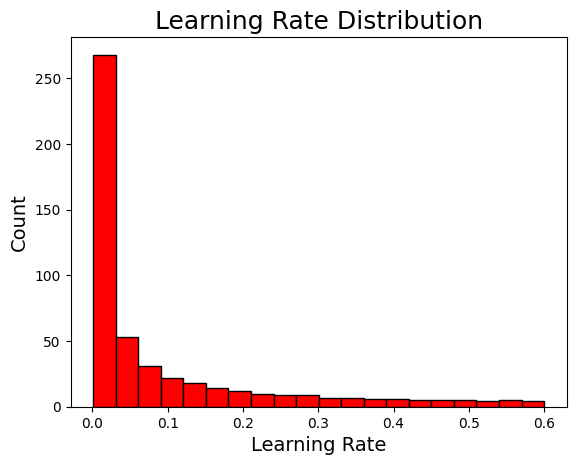

In [37]:
%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['eta'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

Using a logarithmic uniform distribution allows us to create a domain where there are as many values from 0.005 to 0.05 as from 0.05 to 0.5.

This is useful for values that differ over several orders of magnitude such as the learning rate.
 
A logarithmic uniform distribution lets us sample more evenly from a domain that varies over several orders of magnitude.

 In the case of grid search, we input the domain and the algorithm selects the next value for each hyperparameter in an ordered sequence. The only requirement of grid search is that it tries every combination in a grid once (and only once). For random search, we input the domain and each time the algorithm gives us a random combination of hyperparameter values to try. 

Text(0, 0.5, 'Count')

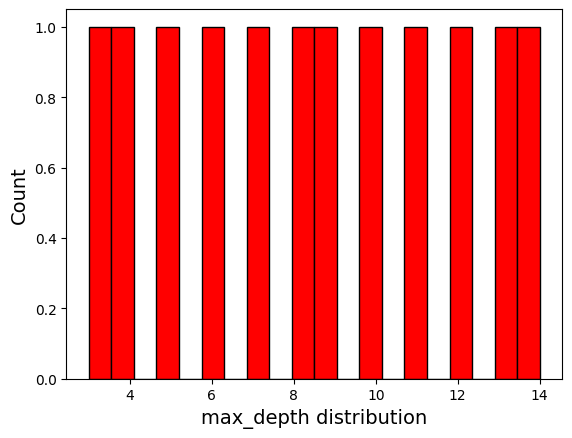

In [139]:
%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['max_depth'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('max_depth distribution', size = 14); plt.ylabel('Count', size = 14)

In [146]:
com = 1
for x in param_grid.values():
    com *= len(x)
    print('There are {} combinations'.format(com))

There are 500 combinations
There are 25000 combinations
There are 1250000 combinations
There are 125000000 combinations
There are 1500000000 combinations
There are 7500000000 combinations
There are 37500000000 combinations
There are 562500000000 combinations
There are 1687500000000 combinations
There are 8437500000000 combinations


## Start grid search

In [20]:
import itertools
grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))


def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

In [23]:
N_FOLD = 10
D_TRAIN = xgb.DMatrix(X_train, label=y_train)
MAX_EVALS = 30
param_grid = {
    'eta': list(np.logspace(np.log10(0.001), np.log10(0.6), base = 10, num = 500)),
    'lambda': list(np.linspace(0.01, 0.2, num = 100)),
    'alpha': list(np.linspace(0.01, 0.2, 100)),
    'gamma': list(np.linspace(0, 20, 100)),
    'max_depth': list(range(3, 15, 1)),
    'subsample': list(np.linspace(0.5, 1, 5)),
    'colsample_bytree': list(np.linspace(0.5, 1, 5)),
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'min_child_weight': list(np.linspace(0.8, 1.2, 5))
}
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.95893

The best hyperparameters were:
{'alpha': np.float64(0.01),
 'colsample_bytree': np.float64(0.5),
 'eta': np.float64(0.001),
 'eval_metric': 'auc',
 'gamma': np.float64(0.0),
 'lambda': np.float64(0.01),
 'max_depth': 3,
 'min_child_weight': np.float64(0.8),
 'n_estimators': 6,
 'objective': 'binary:logistic',
 'subsample': np.float64(0.5)}


In [25]:
grid_search_params = grid_results.loc[0, 'params']
# model_grid_search = XGBClassifier(**grid_search_params, random_state=42)

In [61]:
dtest = xgb.DMatrix(X_test, label=y_test)

grid_search_final_model = xgb.train(
    params=grid_search_params,
    dtrain=D_TRAIN,
    num_boost_round=10000,
    early_stopping_rounds=5,
    evals=[(dtrain, 'training'), (dtest, 'testing')],
    maximize=True,
    verbose_eval=True
)

[0]	training-auc:0.83741	testing-auc:0.69655
[1]	training-auc:0.93393	testing-auc:0.77610
[2]	training-auc:0.93762	testing-auc:0.79139
[3]	training-auc:0.94848	testing-auc:0.80987
[4]	training-auc:0.95741	testing-auc:0.81919
[5]	training-auc:0.95891	testing-auc:0.81488
[6]	training-auc:0.95633	testing-auc:0.81604
[7]	training-auc:0.95479	testing-auc:0.81694
[8]	training-auc:0.95478	testing-auc:0.81751
[9]	training-auc:0.95614	testing-auc:0.81744


In [62]:
grid_search_final_model.attributes()

{'best_iteration': '4', 'best_score': '0.8191889736158259'}

In [71]:
grid_preds = grid_search_final_model.predict(dtest)
threshold = 0.5
y_pred = (grid_preds >= threshold).astype(int)
grid_auc = roc_auc_score(y_test, grid_preds)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Recall (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f'ROC AUC: {grid_auc:.5f}')

Recall (TPR): 0.5235
False Positive Rate (FPR): 0.0994
ROC AUC: 0.81744


# tuning with random search